INTRODUCTION


As students interested in investing and markets, we were motivated to create a sentiment analyzer for equities based on news articles because it can help you make more informed investment decisions. By analyzing the sentiment contained in news articles about a particular stock, one can gain insight into the factors driving market sentiment and how it may change over time. This can help you better understand the risks and potential rewards associated with investing in a particular stock and make more informed buy or sell decisions. Additionally, creating a sentiment analyzer can also be a rewarding intellectual challenge and a great opportunity to learn more about machine learning and natural language processing.



There are several potential benefits to using a sentiment analysis tool to analyze market sentiment behind certain stocks based on news articles:

1. Improved decision making: Sentiment analysis can help investors and traders make more informed decisions about which stocks to buy or sell by providing insight into the overall sentiment around a particular stock.

2. Increased efficiency: Rather than manually reading and analyzing a large number of news articles, a sentiment analysis tool can quickly and accurately process and summarize the sentiment contained in these articles.

3. Real-time analysis: Sentiment analysis tools can analyze news articles in real-time, allowing investors and traders to stay up-to-date with the latest sentiment around a particular stock.

4. Greater understanding: Sentiment analysis can help investors and traders better understand the factors driving market sentiment around a particular stock and how these sentiments may change over time.

5. Enhanced risk management: By providing insight into the overall sentiment around a particular stock, sentiment analysis can help investors and traders better manage risk by identifying potential areas of market uncertainty or volatility.

The program that takes the ticker of a stock and the name of the company as input, and returns the positivity, negativity and neutral scores in the form of a plot for that stock based on articles from marketwatch.com. This program can be used to discover significant financial news articles for prospective securities. They can click the URL for the articles with the highest positivity/negativity/neutral scores and apply their human intuition on the content of the article for more insight. The Wall Street Journal recently wrote an article on the importance of tracking the sentiment of retail investors on social media networks and news articles, and this program facilitates that.

In [1]:
#importing the necessary libraries 
import requests 
from urllib.request import urlopen
import pandas as pd
import re
import html 
from bs4 import BeautifulSoup 
!pip install htmldate
!pip install transformers
!pip install -U htmldate[all]
from htmldate import find_date
from datetime import datetime
from transformers import AutoTokenizer, AutoModelForSequenceClassification
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")
from matplotlib import pyplot as plt
import numpy as np
from matplotlib.dates import DateFormatter
import torch
from sklearn import linear_model

/usr/local/lib/python3.8/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.13) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached urllib3-1.25.11-py2.py3-none-any.whl (127 kB)
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.26.13
    Uninstalling urllib3-1.26.13:
      Successfully uninstalled urllib3-1.26.13
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
htmldate 1.4.0 requires urllib3<2,>=1.26, but you have urllib3 1.25.11 which is incompatible.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached urllib3-1.26.13-py2.py3-none-any.whl (140 kB)
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.25.11
    Uninstalling urllib3-1.25.11:
      Successfully uninstalled urllib3-1.25.11
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
requests 2.23.0 requires urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you have urllib3 1.26.13 which is incompatible.


On the software development side, during the course of this project we learned to always be cognizant of our end users . We focused on making this an on-demand tool that can be run by my users within 2–3 minutes. This constrained how much data we allowed the program to analyze due to my limited computing power.
We also had to make sure my program is easily usable by non-technical users, since the fundamental analysts who are interested in stock research are usually Finance majors that don’t have much coding experience. As a result, we hid away most of the technical code, and only exposed an intuitive code block for users to put in inputs like the stock ticker and company name:

In [2]:
#Asking the user to input the ticker and company name in lowercase for processing 
ticker = input("Enter the stock ticker in lowercase(examples: amzn, tsla, k): " )
company = input("Enter the company name in lowercase(examples: amazon, tesla, kellogg): ")

Enter the stock ticker in lowercase(examples: amzn, tsla, k): nvda
Enter the company name in lowercase(examples: amazon, tesla, kellogg): nvidia


As with any Data Science project, the bulk of technical challenges came from fetching and cleaning the raw news text data to prepare it for the an appropriate sentiment analyzer model that can process words in a financial context


It was hard to find a credible financial news source that would also allow one to scrape content from its website. After unsuccessful attempts at scraping news articles from nasdaq.com and benzinga.com due to their anti-scraping mechanism, we finally found a perfect solution using marketwatch.com as they not only have credible news articles but also believe in open data access.


In [3]:
#Specifying the skeleton of the html link for all stocks on marketwatch.com with just the ticker being different for each stock
news_url = 'https://www.marketwatch.com/investing/stock/' + ticker + '?mod=quote_search'

In [4]:
#Getting the html code for the webpage pertaining to the html link 
html = requests.get(news_url).content
    
#Converting the html code to a beautiful soup object 
soup = BeautifulSoup(html , 'lxml')

#Getting a list of all links on the webpage 
links = soup.find_all('a')

In [5]:
#Searching for the destination of the required hyperlinks on the webpage 
urls = []
for link in links:
    urls.append(link.get('href'))

None values made our code more error-prone. We ended up with a runtime error and unexpected behavior in our code. This then got us to handling the None values in our code. 

In [6]:
#Selecting the links that are not None 
urls1 = []
for url in urls:
    if url is not None:
       urls1.append(url)

We only wanted links that pertain to news articles and so we added a filter where we only scrape the links that begin with "https". Further the news links from fool.com were giving us errors possibly due to security reasons. Therefore we also avoided those news articles. 

In [7]:
#Selectng the urls that begin with "https" 
news_urls = []
substring = 'https://'
substring1 = 'fool.com'
for url in urls1:
    if substring in url and substring1 not in url:
       news_urls.append(url)

While scrapping the news articles, we noticed that our code scrapes news articles that are not related to the company we want and are random articles on the webpage. This is why we decided to add another layer of filteration and only scrape the news article links that contain the name of the company that the user inputs. 

In [8]:
#Selecting the urls that pertain to the stock articles of the required company 
company_news_urls = []
substring2 = company
for url in news_urls:
    if substring2 in url:
       company_news_urls.append(url)

While scrapping news links we saw that our code scraps multiple same news links. This is a common occurance when scraping data from an html file. We decided to remove the duplicate news links so that each article is only present once in our dataset

In [9]:
#Removing the duplicate urls for any given article link scrapped
links_unique = []
for x in company_news_urls:
    if x not in links_unique and x is not None:
       links_unique.append(x)

dates = []

We decided to get the date of publication of the articles so that we can use it while plotting our finindings. When the end user sees the date corresponding to a particular article, it can affect his/her opionion as finance is a very time sensitive industry and sentiments can change very quickly. 

In [10]:
#Getting the publishing dates of the scrapped articles 
for link in links_unique:
    date = find_date(link)
    dates.append(date)

In [11]:
#Initializing a list to store the news text present in the scrapped links
news_text_list = []
for url in links_unique:

    #Getting the html code for the webpages that have the news text 
    r = requests.get(url,headers = {'User-Agent': 'Popular browser\'s user-agent',}).content
        
    #Handling the html code for these news articles using the lxml interface to parse the content to beautiful soup
    news_soup = BeautifulSoup(r , 'lxml')
     
    #Locating the different paragraphs in the article and concatinating them into a string paragraph
    paragraphs = [par.text for par in news_soup.find_all('p')]
    news_text = '\n'.join(paragraphs)
    
    #Appending the final news text into the news text list 
    news_text_list.append(news_text)

In [12]:
#Creating a pandas dataframe to store data 
df = pd.DataFrame()

#Creating a column to store the links for the various scrapped articles
df['News links'] = links_unique

#Creating a column that stores the news text of the various articles
df['News text'] = news_text_list

#Creating a column to store the publishing fdate of the scrapped articles 
df['Date'] = dates

Data cleaning being one of the most important tasks in any data science project, was something we addressed in this project as well.
For each news article we cleant the raw text by applying the following cleaning procedures:

1. Tokenizing words

2. Removing URL links

3. Removing newline and whitespace characters
 
The reason we laid emphasis on cleaning the data is because we wanted to remove all the unnecessary data/noise present in the data in order to get the most accurate results possible from our NLP model.


In [13]:
#Basic data cleaning steps 
for index, row in df.iterrows():
    #Removing newline characters
    row['News text'] = row['News text'].replace("\n", "")
    #Removing whitespace characters
    row['News text'] = " ".join(row['News text'].split())
    #Removing links that are not relavant to the text
    row['News text'] = re.sub(r'http\S+', '', row['News text'])

**Finding an appropriate model that can work for financial jargon**

This part of the project was where we had major technical roadblocks as we could not find appropriate readymade datasets on financial lexical sentiment. After a lot of digging we decided it is best to use FinBERT which is a pre-trained, open source NLP model to analyze sentiment of financial text developed by GOOGLE. This made the entire process a lot more straightforward and we had to just ensure that our data is modified well enough in order to be run through the model.


In [14]:
#Tokenizing the words to help the NLP model in interpreting the meaning of the text by analyzing the sequence of the words.
inputs = tokenizer(news_text_list, padding = True, truncation = True, return_tensors='pt')

#Running the tokenized text through the FinBERT NLP model 
outputs = model(**inputs)

#Generating the sentiment score predictions for these news articles 
predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)

#Storing the positive, negatibve and neutral scores for each article into seperate lists
positive = predictions[:, 0].tolist()
negative = predictions[:, 1].tolist()
neutral = predictions[:, 2].tolist()

In [15]:
#Creating a dataframe that has the news text, publishing date and the respective sentiment scores on it 
table = {'News Text':news_text_list,
         "Positive":positive,
         "Negative":negative, 
         "Neutral":neutral}
df = pd.DataFrame(table, columns = ["News Text", "Date", "Positive", "Negative", "Neutral"])
df['Date'] = dates
df['Article link'] = links_unique

We decided to plot an additional plot that displays the average sentiment score of the particular stock that the user inputs. In order to do this we had to calculate the average positive, neutral and negative sentiment scores.

In [16]:
#Finding the average of the different sentiment scores for all the scrapped articles 
Negative_score = df['Negative'].values.tolist()
Negative_sum = sum(Negative_score)
Negative_sum /= df.shape[0]
Positive_score = df['Positive'].values.tolist()
Positive_sum = sum(Positive_score)
Positive_sum /= df.shape[0]
Neutral_score = df['Neutral'].values.tolist()
Neutral_sum = sum(Neutral_score)
Neutral_sum /= df.shape[0]

We decided to sort the values by date so that the user can see the latest news articles grouped together and not spend time manually looking for them.

In [17]:
#Sorting the data in the data frame by date of publication 
df = df.sort_values(by ='Date')

#Converting the dates to a date-time object and storing the scores and dates in respective lists 
df['Date'] = pd.to_datetime(df['Date']).dt.date
negative_score = df['Negative']
positive_score = df['Positive']
neutral_score = df['Neutral']
dates_list = df['Date']
links_final = df['Article link']

To plot the sentiment scores we decided to use red for negative sentiment scores, green for the positive ones and blue for the neutral ones. A bar plot was the most logical to use in this scenario. 

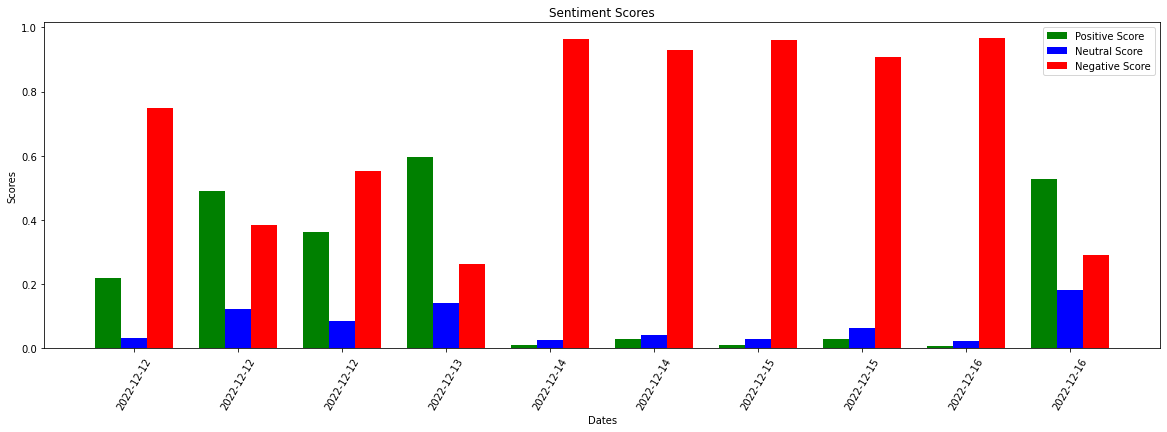


2022-12-16 , https://www.marketwatch.com/story/nvidia-corp-stock-falls-friday-underperforms-market-01671228847-c1423b84bd97?mod=mw_quote_news

2022-12-16 , https://www.marketwatch.com/articles/nvidia-amd-qualcomm-chip-stocks-51671214521?mod=mw_quote_news

2022-12-15 , https://www.marketwatch.com/story/nvidia-corp-stock-falls-thursday-underperforms-market-01671142478-28a622ea578c?mod=mw_quote_news

2022-12-14 , https://www.marketwatch.com/story/nvidia-corp-stock-falls-wednesday-underperforms-market-01671056082-f61fe8a4906f?mod=mw_quote_news

2022-12-13 , https://www.marketwatch.com/story/nvidia-corp-stock-rises-tuesday-outperforms-market-01670969690-c9f96c05c7be?mod=mw_quote_news

2022-12-12 , https://www.marketwatch.com/story/why-nvidia-is-this-analysts-top-stock-pick-for-2023-11670870363?mod=mw_quote_news

2022-12-12 , https://www.marketwatch.com/story/nvidia-corp-stock-rises-monday-outperforms-market-01670883290-e84601734d52?mod=mw_quote_news

2022-12-12 , https://www.marketwatch.co

In [18]:
#Creating a plot using matplotlib
plt.figure(figsize = (20,6))

#getting the number of x axis values that need to be plotted and specifying the width of the bars in the plot
N = len(dates_list)
ind = np.arange(N) 
width = 0.25
  
#Representing the positive scores in a green bar 
xvals = positive_score
bar1 = plt.bar(ind, xvals, width, color = 'g')

#Representing the neutral scores in a blue bar 
zvals = neutral_score
bar3 = plt.bar(ind+width, zvals, width, color = 'b')

#Representing the negative scores in a red bar 
yvals = negative_score
bar2 = plt.bar(ind+width*2, yvals, width, color='r')
  
#Labelling the axis and the title of the plot
plt.xlabel("Dates")
plt.ylabel('Scores')
plt.title("Sentiment Scores")

#Making certain orientation adjustments and creating a legend for the plot
plt.xticks(ind+width,dates_list)
plt.xticks(rotation=60)
plt.legend((bar1, bar3, bar2), ('Positive Score', 'Neutral Score', 'Negative Score'))
plt.show()


#Printing a newline
print()

#Printing the dates and links in the dataframe
for i in range (0,len(dates_list)):
    print(dates_list[i].strftime('%Y-%m-%d') + ' , ' + links_final[i] + "\n")

#Printing a newline
print()

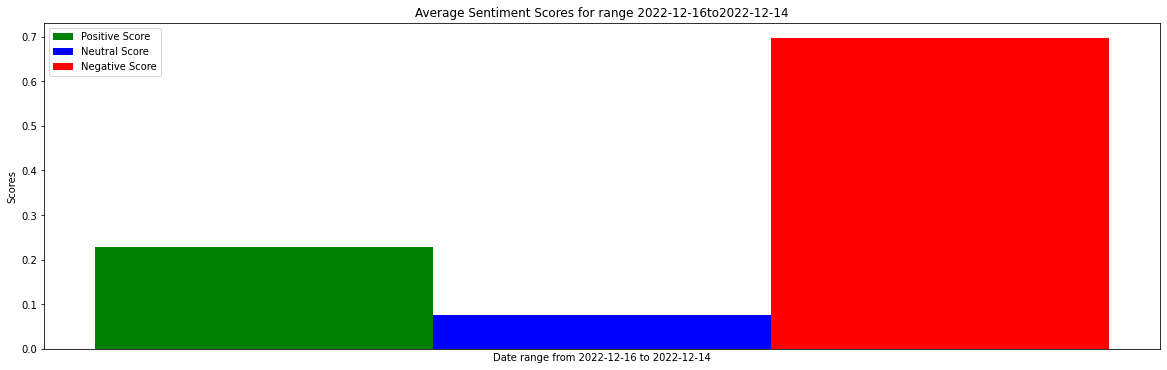

In [19]:
plt.figure(2, figsize = (20,6))
#getting the number of x axis values that need to be plotted and specifying the width of the bars in the plot
M = 1
ind = np.arange(M) 
width = 0.7
  
#Representing the positive scores in a green bar 
xvals = Positive_sum
bar1 = plt.bar(ind, xvals, width, color = 'g')

#Representing the neutral scores in a blue bar 
zvals = Neutral_sum
bar3 = plt.bar(ind+width, zvals, width, color = 'b')

#Representing the negative scores in a red bar 
yvals = Negative_sum
bar2 = plt.bar(ind+width*2, yvals, width, color='r')
  
#Labelling the axis and the title of the plot
plt.xlabel("Date range from " + str(dates_list[0]) + " to " + str(dates_list[N-1]))
plt.ylabel('Scores')
plt.title("Average Sentiment Scores for range " + str(dates_list[0]) + "to" + str(dates_list[N-1]))

#Making certain orientation adjustments and creating a legend for the plot
plt.xticks([])
plt.legend((bar1, bar3, bar2), ('Positive Score', 'Neutral Score', 'Negative Score'))
plt.show()

**Things learnt**
 
On the data science side, We learnt a lot about picking the right data. The time constraint of 2–3 minutes for the entire program forced me to pick only the highest-leverage data, which happened to be the default ~ plain news texts pertaining to stocks.
We also learned about the importance of cleaning data especially when running your data through a pre-trained model. Data cleaning is important because it improves your data quality and in doing so, increases overall productivity of the program. Incorrect data may lead to the model making bad decisions. Cleaning the data requires removal of duplications, removing or replacing missing entries, correcting misfielded values, ensuring consistent formatting and a host of other tasks which take a considerable amount of time but are essential to any data science project.
Further we learned about the importance of delivering final results that are visually appealing to the user. The use of plots to depict sentiment scores help in showing a large amount of data quickly in a way that is easy to process, without distracting people with a bunch of numbers. Further we also decided to include a plot for the average sentiment scores of the stock for a particular time period as a bonus!


# Hypothesis Test: Part 1
Cleaning the Data

This hypothesis test uses a linear regression model to find a trend in the sentiment score vs the actual percent changes over the course of 5 days. We chose to perform this kind of test to determine if the calculated sentiment score had a measureable association with the actual stock trading price for five stocks each day. This model has scores from December 7, 8, 9, 12, and 13 in 2022 and looks for relationships with Verizon, Pfizer, Meta, Nvidia, and Chevron stocks. After downloading the opening and closing price for each of the five stocks from yahoo finance, we were able to compute the percent change of each stock for each day and match it to the program's sentiment score. A linear regression formula was able to compute an r-squared value, allowing us to determine how correlated these two values are.


In [20]:
#Importing the data from csv files to pandas dataframes
verizon_table = pd.read_csv('VZ.csv')
pfizer_table = pd.read_csv('PFE.csv')
meta_table = pd.read_csv('META.csv')
nvidia_table = pd.read_csv('NVDA.csv')
chevron_table = pd.read_csv('CVX.csv')

In [21]:
#Cleaning up the data to only contain the values that we want, the date, open, and close values between 
#December 7, 2022 and December 13, 2022
verizon_table = verizon_table[247:252]
verizon_table.drop(['High','Low','Adj Close', 'Volume'],axis=1,inplace=True)
verizon_table = verizon_table.reset_index()

pfizer_table = pfizer_table[247:252]
pfizer_table.drop(['High','Low','Adj Close', 'Volume'],axis=1,inplace=True)
pfizer_table = pfizer_table.reset_index()

meta_table = meta_table[247:252]
meta_table.drop(['High','Low','Adj Close', 'Volume'],axis=1,inplace=True)
meta_table = meta_table.reset_index()

nvidia_table = nvidia_table[247:252]
nvidia_table.drop(['High','Low','Adj Close', 'Volume'],axis=1,inplace=True)
nvidia_table = nvidia_table.reset_index()

chevron_table = chevron_table[247:252]
chevron_table.drop(['High','Low','Adj Close', 'Volume'],axis=1,inplace=True)
chevron_table = chevron_table.reset_index()

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [22]:
#Combining each table into one pandas dataframe
table = pd.concat([verizon_table, pfizer_table, meta_table, nvidia_table, chevron_table])
table.insert(0,'Stock', '')
table = table.reset_index()
table.drop(['index', 'level_0'], axis=1, inplace=True)

table.loc[[0,1,2,3,4], 'Stock'] = 'Verizon'
table.loc[[5,6,7,8,9], 'Stock'] = 'Pfizer'
table.loc[[10,11,12,13,14], 'Stock'] = 'Meta'
table.loc[[15,16,17,18,19], 'Stock'] = 'Nvidia'
table.loc[[20,21,22,23,24], 'Stock'] = 'Chevron'

In [23]:
#Adding a percent change column to each table
table['Percent Change'] = 0.0

#Computing the percentage change on the day for each stock and adding it to table
for i in range(0, 25):
    table.loc[i, 'Percent Change'] = (
        (table.loc[i, 'Open'] - table.loc[i, 'Close']) / table.loc[i, 'Open']) * 100

The data for this hypothesis test was collected at the end of the day on December 13, 2022. Since the program continuously updates the articles checked, the data had to be inputted manually and collected at a specific time. Below are the scores for the positive, negative, and neutral values. 

In [24]:
#Adding the average delta score and neutral score for stocks on each day manually.
verizon_positive = [0.028, 0.031, 0.008, 0.426, 0.021]
verizon_negative = [-0.174, -0.943, -0.974, -0.542, -0.968]
verizon_neutral = [0.798, 0.025, 0.017, 0.032, 0.012]

pfizer_positive = [0.179, 0.428, 0.212, 0.418, 0.648]
pfizer_negative = [-0.726, -0.539, -0.241, -0.046, -0.027]
pfizer_neutral = [0.206, 0.113, 0.546, 0.536, 0.324]

meta_positive = [0.007, 0.402, 0.091, 0.349, 0.259]
meta_negative = [-0.93, -0.201, -0.766, -0.273, -0.411]
meta_neutral = [0.084, 0.538, 0.219, 0.376, 0.33]

nvidia_positive = [0.012, 0.014, 0.347,  0.297, 0.442]
nvidia_negative = [-0.954, -0.612, -0.975, -0.2495, -0.5315]
nvidia_neutral = [0.031, 0.041, 0.018, 0.446, 0.027]

chevron_positive = [0.024, 0.044, 0.075, 0.581, 0.353]
chevron_negative = [-0.947, -0.929, -0.497, -0.165, -0.042]
chevron_neutral = [0.029, 0.031, 0.428, 0.254, 0.605]

#Combining all positive, negative, and neutral score arrays in the correct order
positives = verizon_positive + pfizer_positive + meta_positive + nvidia_positive + chevron_positive
negatives = verizon_negative + pfizer_negative + meta_negative + nvidia_negative + chevron_negative
neutrals = verizon_neutral + pfizer_neutral + meta_neutral + nvidia_neutral + chevron_neutral

#Adding the ordered list of values to the table
table['Positive Score'] = positives
table['Negative Score'] = negatives
table['Neutral Score'] = neutrals

table

,Stock,Date,Open,Close,Percent Change,Positive Score,Negative Score,Neutral Score
0,Verizon,2022-12-07,36.740002,37.169998,-1.170376,0.028,-0.1740,0.798
1,Verizon,2022-12-08,37.110001,37.099998,0.026955,0.031,-0.9430,0.025
2,Verizon,2022-12-09,37.209999,37.400002,-0.510624,0.008,-0.9740,0.017
3,Verizon,2022-12-12,37.689999,37.950001,-0.689843,0.426,-0.5420,0.032
4,Verizon,2022-12-13,38.389999,37.860001,1.380563,0.021,-0.9680,0.012
5,Pfizer,2022-12-07,49.750000,50.240002,-0.984929,0.179,-0.7260,0.206
6,Pfizer,2022-12-08,50.180000,51.779999,-3.188519,0.428,-0.5390,0.113
7,Pfizer,2022-12-09,51.750000,51.720001,0.057969,0.212,-0.2410,0.546
8,Pfizer,2022-12-12,52.119999,52.160000,-0.076748,0.418,-0.0460,0.536
9,Pfizer,2022-12-13,53.099998,53.070000,0.056493,0.648,-0.0270,0.324


To choose the proper value, we decided to select the score that had the greatest absolute value. To the user, the greatest score is the value that they would based their opinion on since for many of the plots, one score tends to outweigh the other by a significant amount.

In [25]:
#Looping through and choosing the greatest score.
table['Chosen Value'] = 0.0   

for index, row in table.iterrows():
    chosen_value = max([table.loc[index, 'Positive Score'],
                        abs(table.loc[index, 'Negative Score']),
                        table.loc[index, 'Neutral Score']])
    if (chosen_value * -1) == table.loc[index, 'Negative Score']:
      chosen_value *= -1
    table.loc[index, 'Chosen Value'] = chosen_value

#Hypothesis Test: Part 2
Testing the Data

Null hypothesis: There is no relationship between the sentiment score and the stock price change.

Alternate hypothesis: There is a relationship between the sentiment score and the stock price change.

In [26]:
#Creating a linear regression model for the sentiment score vs the stock change to determine 
#the correlation of the two values.
linreg = linear_model.LinearRegression()
x_vals = [[x] for x in table['Chosen Value'].values]
y_vals = [[y] for y in table['Percent Change'].values]
fit = linreg.fit(x_vals, y_vals)
score = linreg.score(x_vals, y_vals)
print('Coefficient: %f' % fit.coef_)
print('Intercept: %.2f' % fit.intercept_)
print('Regression Score: %.2f' % score)

Coefficient: -0.066924
Intercept: -0.31
Regression Score: 0.00


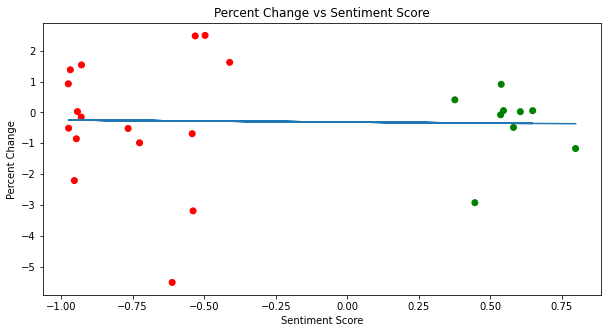

In [27]:
#Creating a plot to visually represent this model
plt.figure(figsize=(10,5))
plt.scatter(table['Chosen Value'], table['Percent Change'], c=['g' if x > 0 else 'r' for x in table['Chosen Value']])
plt.xlabel("Sentiment Score")
plt.ylabel("Percent Change")
plt.title("Percent Change vs Sentiment Score")

plt.plot(x_vals, fit.intercept_ + (fit.coef_ * x_vals))

plt.show()

We can not reject the null hypothesis because this linear regression model has an r-squared value of 0.00, showing that this test does not convey a relationship between the percent change and the predicted sentiment score. This lack of relationship could be rejected with other tests, but this test is not able to show any relationship between the sentiment score and percent change simply due to the lack of correlation between the data. The linear regression model was unable to produce any relationship value, and therefore led to this conclusion.